In [ ]:
import pandas as pd
import numpy as np
import os

df = pd.read_csv('./data/train.csv')
sub = pd.read_csv('./data/sample_submission.csv')

# Make sure sorted by date
df = df.sort_values(by='date')
sub = sub.sort_values(by='date')

# Format date as date
df["date"] = pd.to_datetime(df["date"]).dt.date
sub["date"] = pd.to_datetime(sub["date"]).dt.date

In [ ]:
df.head()

In [ ]:
# This is going to be a common problem to fix, but tracking is doubled 9/27/2017 and 6/12/2018

def fix_double_tracking(df, col, date_col="date"):
    df.loc[(df[date_col] <= pd.to_datetime("2018-06-12").date()) & (df[date_col] >= pd.to_datetime("2017-09-27").date()), col] = \
    df.loc[(df[date_col] <= pd.to_datetime("2018-06-12").date()) & (df[date_col] >= pd.to_datetime("2017-09-27").date()), col] / 2
    return df


In [ ]:
# sleep_hours between 9/27/2017 and 6/12/2018 is doubled and needs to be divided by 2
df = fix_double_tracking(df, "sleep_hours")

In [ ]:
df.sleep_hours.hist()

In [ ]:
# Fill in missing dates (for time series)

start_date = df["date"].min()
print(f"Start date: {start_date}")

end_date = df["date"].max()
print(f"End date: {end_date}")

date_range = pd.date_range(start=start_date, end=end_date, freq="D")
date_range = pd.DataFrame({"date": date_range})
date_range["date"] = date_range["date"].dt.date

df = date_range.merge(df, on="date", how="left")
print('missing days: ', df.sleep_hours.isna().sum())

In [ ]:
# forward fill the missing values/targets
df["sleep_hours"] = df["sleep_hours"].fillna(method="ffill")

In [ ]:
#plot df_sleep.sleep_hours as dots by df_sleep.date
df.plot.scatter(x='date', y='sleep_hours')

In [ ]:
# Median of sleep_hours
med = df.sleep_hours.median()
print(f"Median sleep hours: {med}")


In [ ]:
sub_median = sub.copy()
sub_median["sleep_hours"] = med
sub_median.to_csv("./submissions/submission_median.csv", index=False)
sub_median.head()

# kaggle competitions submit -c kaggle-pog-series-s01e04 -f ./submissions/submission_median.csv -m "Trying just all median"
# Score : 0.67685

In [ ]:
# Median of sleep_hours
mean = df.sleep_hours.mean()
print(f"Median sleep hours: {mean}")

In [ ]:
sub_mean = sub.copy()
sub_mean["sleep_hours"] = mean
sub_mean.to_csv("./submissions/submission_mean.csv", index=False)
sub_mean.head()

# kaggle competitions submit -c kaggle-pog-series-s01e04 -f ./submissions/submission_mean.csv -m "Trying just all mean"
# Score: 0.67396

In [ ]:
import pytz
from datetime import datetime, timedelta
from pandas.tseries.holiday import USFederalHolidayCalendar
### Time series Data ###

df["day_of_week"] = pd.to_datetime(df["date"]).dt.dayofweek # Day of the week
df["month"] = pd.to_datetime(df["date"]).dt.month # Month
df["is_weekend"] = df["day_of_week"].apply(lambda x: 1 if x >= 5 else 0) # is_weekend

cal = USFederalHolidayCalendar()
holidays = cal.holidays(start="2014-01-01", end="2023-12-31") 
df["is_holiday"] = df["date"].apply(lambda x: 1 if x in holidays else 0) # is_holiday
df["is_workday"] = 1-(df["is_weekend"] + df["is_holiday"]) # is_workday

In [ ]:
df.head()

In [ ]:
# Create submissions by median by DOW
sub_median_group = sub.copy()
med = df.groupby("day_of_week")["sleep_hours"].median()
sub_median_group["day_of_week"] = pd.to_datetime(sub_median_group["date"]).dt.dayofweek
sub_median_group["sleep_hours"] = sub_median_group["day_of_week"].map(med)
sub_median_group = sub_median_group.drop("day_of_week", axis=1)
sub_median_group.to_csv("./submissions/submission_median_group.csv", index=False)
sub_median_group.head()

# kaggle competitions submit -c kaggle-pog-series-s01e04 -f ./submissions/submission_median_group.csv -m "Trying all median by DOW"
# Score: 0.67406

In [ ]:
# Create submissions by median by DOW
sub_mean_group = sub.copy()
mean = df.groupby("day_of_week")["sleep_hours"].mean()
sub_mean_group["day_of_week"] = pd.to_datetime(sub_mean_group["date"]).dt.dayofweek
sub_mean_group["sleep_hours"] = sub_mean_group["day_of_week"].map(mean)
sub_mean_group = sub_mean_group.drop("day_of_week", axis=1)
sub_mean_group.to_csv("./submissions/submission_mean_group.csv", index=False)
sub_mean_group.head()

# kaggle competitions submit -c kaggle-pog-series-s01e04 -f ./submissions/submission_mean_group.csv -m "Trying all mean by DOW"
# Score: ________________

In [ ]:
# Submission by median by DOW and and is_workday
sub_median_group_workday = sub.copy()
med = df.groupby(["day_of_week", "is_workday"])["sleep_hours"].median()
sub_median_group_workday["day_of_week"] = pd.to_datetime(sub_median_group_workday["date"]).dt.dayofweek
sub_median_group_workday["is_workday"] = 1-(sub_median_group_workday["day_of_week"].apply(lambda x: 1 if x >= 5 else 0) + sub_median_group_workday["date"].apply(lambda x: 1 if x in holidays else 0))
sub_median_group_workday["sleep_hours"] = sub_median_group_workday[["day_of_week", "is_workday"]].apply(lambda x: med[x[0]][x[1]], axis=1)
sub_median_group_workday = sub_median_group_workday.drop(["day_of_week", "is_workday"], axis=1)
sub_median_group_workday.to_csv("./submissions/submission_median_group_workday.csv", index=False)
sub_median_group_workday.head()
# kaggle competitions submit -c kaggle-pog-series-s01e04 -f ./submissions/submission_median_group_workday.csv -m "Trying all median by DOW and is_workday"
# Score: __________________

In [ ]:
# Submission by mean by DOW and and is_workday
sub_mean_group_workday = sub.copy()
mean = df.groupby(["day_of_week", "is_workday"])["sleep_hours"].mean()
sub_mean_group_workday["day_of_week"] = pd.to_datetime(sub_mean_group_workday["date"]).dt.dayofweek
sub_mean_group_workday["is_workday"] = 1-(sub_mean_group_workday["day_of_week"].apply(lambda x: 1 if x >= 5 else 0) + sub_mean_group_workday["date"].apply(lambda x: 1 if x in holidays else 0))
sub_mean_group_workday["sleep_hours"] = sub_mean_group_workday[["day_of_week", "is_workday"]].apply(lambda x: mean[x[0]][x[1]], axis=1)
sub_mean_group_workday = sub_mean_group_workday.drop(["day_of_week", "is_workday"], axis=1)
sub_mean_group_workday.to_csv("./submissions/submission_mean_group_workday.csv", index=False)
sub_mean_group_workday.head()
# kaggle competitions submit -c kaggle-pog-series-s01e04 -f ./submissions/submission_mean_group_workday.csv -m "Trying all mean by DOW and is_workday"
# Score: ________________

In [ ]:
from glob import glob

csv_files = glob("./data/xml_export/*.csv")

# Keep what files have ~80% of the dates in the training data
unique_dates = set(df["date"])

match_threshold = 0.75 # Threshold for matching

def intersection_ratio(set1, set2):
    return len(set1 & set2) / len(set1)

matching_csvs = []
for csv_file in csv_files:
    csv_df = pd.read_csv(csv_file)  
    try: 
        csv_df["date"] = pd.to_datetime(csv_df["startDate"]).dt.date
    except:
        csv_df["date"] = pd.to_datetime(csv_df["dateComponents"]).dt.date # Some use dateComponents instead of startDate

    unique_creation_dates = set(csv_df)

    ratio = intersection_ratio(unique_dates, unique_creation_dates)

    if ratio >= match_threshold:
        matching_csvs.append(csv_file)

print("CSV files with at least 75% of the 'dates' from the original DataFrame:")
for matching_csv in matching_csvs:
    print(matching_csv)

In [ ]:

csv_df.loc[csv_df["date"] >= pd.to_datetime("2021-01-01").date()]

In [ ]:
list = ["test1", "test2", "test3"]


In [ ]:
# Datasets worth exploring
basal_energy_burned = pd.read_csv('./data/xml_export/BasalEnergyBurned.csv', low_memory=False)
body_mass = pd.read_csv('./data/xml_export/BodyMass.csv', low_memory=False)
flights_climbed = pd.read_csv('./data/xml_export/FlightsClimbed.csv', low_memory=False)
step_count = pd.read_csv('./data/xml_export/StepCount.csv', low_memory=False)
body_mass_index = pd.read_csv('./data/xml_export/BodyMassIndex.csv', low_memory=False)
distance_walking_running = pd.read_csv('./data/xml_export/DistanceWalkingRunning.csv', low_memory=False)


In [ ]:

def parse_xml_output(path):
    # Import the csv
    csv_df = pd.read_csv(path, low_memory=False)
    base_name = os.path.basename(path).split(".")[0]
    
    # BodyMassIndex we want to avg not sum
    if base_name == "BodyMassIndex":
        agg_func = "mean"
    else:
        agg_func = "sum"
    
    # Convert startDate and endDate columns to datetime objects
    csv_df["startDate"] = pd.to_datetime(csv_df["startDate"]).dt.tz_convert ("US/Eastern")
    csv_df["endDate"] = pd.to_datetime(csv_df["endDate"]).dt.tz_convert ("US/Eastern")
    # Create date & time column
    csv_df["date"] = pd.to_datetime(csv_df["startDate"]).dt.date
    csv_df["time"] = pd.to_datetime(csv_df["startDate"]).dt.time
    
    # Group by date and perform aggregations
    csv_df = csv_df.groupby("date").agg(
        max_start_time=pd.NamedAgg(column="startDate", aggfunc="max"),
        min_start_time=pd.NamedAgg(column="startDate", aggfunc="min"),
        max_end_time=pd.NamedAgg(column="endDate", aggfunc="max"),
        min_end_time=pd.NamedAgg(column="endDate", aggfunc="min"),
        value_sum=pd.NamedAgg(column="value", aggfunc=agg_func)
    ).reset_index()
    
    # Check if the dates match between min_start_time and max_end_time
    csv_df["dates_match"] = csv_df.apply(
        lambda row: row["min_start_time"].date() == row["max_end_time"].date(), axis=1)
    csv_df = csv_df.rename(columns={"value_sum": base_name})
    
    # Assert if dates match in all rows
    # assert csv_df["dates_match"].all(), "Dates do not match in some rows"
    
    # Trigonomic Hours
    csv_df[base_name+"_mx_st_hr_sin"] = np.sin(2 * np.pi * csv_df["max_start_time"].dt.hour / 24)
    csv_df[base_name+"_mx_st_hr_cos"] = np.cos(2 * np.pi * csv_df["max_start_time"].dt.hour / 24)
    csv_df[base_name+"_mn_st_hr_sin"] = np.sin(2 * np.pi * csv_df["min_start_time"].dt.hour / 24)
    csv_df[base_name+"_mn_st_hr_cos"] = np.cos(2 * np.pi * csv_df["min_start_time"].dt.hour / 24)
    csv_df[base_name+"_mx_et_hr_sin"] = np.sin(2 * np.pi * csv_df["max_end_time"].dt.hour / 24)
    csv_df[base_name+"_mx_et_hr_cos"] = np.cos(2 * np.pi * csv_df["max_end_time"].dt.hour / 24)
    csv_df[base_name+"_mn_et_hr_sin"] = np.sin(2 * np.pi * csv_df["min_end_time"].dt.hour / 24)
    csv_df[base_name+"_mn_et_hr_cos"] = np.cos(2 * np.pi * csv_df["min_end_time"].dt.hour / 24) 
    
    #! HIGHLY ILLEGAL FEATURE??? (Step Count basically calculates sleep time)
    # Hours between startDate and next startDate (lag = -1)
    csv_df[base_name+"_hours_between"] = (csv_df["min_start_time"].shift(-1) - csv_df["max_start_time"]).dt.total_seconds() / 3600
    
    #Fix double tracking
    csv_df = fix_double_tracking(csv_df, base_name)
    
    # Drop unnecessary columns
    # csv_df = csv_df.drop(columns=["max_start_time", "min_start_time", "max_end_time", "min_end_time", "dates_match"])

    return csv_df

## Basal Energy Burned

In [ ]:
basal_energy_burned.head()

In [ ]:
# Value is the only useful feature
# Group by date and sum (set alias to basal_energy_burned)

# NOTE: Summing assumes duplicate tracking is not occuring between devices

basal_energy_burned = parse_xml_output("./data/xml_export/BasalEnergyBurned.csv")
basal_energy_burned.head()

In [ ]:
# Check distribution
basal_energy_burned.BasalEnergyBurned.hist()

In [ ]:
basal_energy_burned.plot.scatter(x='date', y='BasalEnergyBurned')

Looks like Rob got a better tracker or became more serious about racking in 2021

# Body Mass

In [ ]:
body_mass.head()

In [ ]:
body_mass["date"] = pd.to_datetime(body_mass["startDate"]).dt.date
body_mass = body_mass.groupby("date").sum().reset_index()
body_mass = body_mass.rename(columns={"value": "body_mass"})
body_mass = fix_double_tracking(body_mass, "body_mass")
body_mass.head()

In [ ]:
# Check distribution
body_mass.body_mass.hist()

In [ ]:
body_mass.plot.scatter(x='date', y='body_mass')

## Flights Climbed

In [ ]:
flights_climbed.head()

In [ ]:
flights_climbed["date"] = pd.to_datetime(flights_climbed["startDate"]).dt.date
flights_climbed = flights_climbed.groupby("date").sum().reset_index()
flights_climbed = flights_climbed.rename(columns={"value": "flights_climbed"})
flights_climbed = fix_double_tracking(flights_climbed, "flights_climbed")
flights_climbed.head()

In [ ]:
# Check distribution
flights_climbed.flights_climbed.hist()

# Definitely lognormal

In [ ]:
flights_climbed.plot.scatter(x='date', y='flights_climbed')

Very weird data. Will have to explore further. Possible duplication?

## Step Count

In [ ]:
step_count.head()

In [ ]:
step_count["date"] = pd.to_datetime(step_count["startDate"]).dt.date
step_count = step_count.groupby("date").sum().reset_index()
step_count = step_count.rename(columns={"value": "step_count"})
step_count = fix_double_tracking(step_count, "step_count")
step_count.head()

In [ ]:
# Check distribution
step_count.step_count.hist()

#kind of lognormal but not quite

In [ ]:
step_count.plot.scatter(x='date', y='step_count')

## Body Mass Index
This is a slow changing variable


In [ ]:
body_mass_index.head()

In [ ]:
body_mass_index["date"] = pd.to_datetime(body_mass_index["startDate"]).dt.date
body_mass_index = body_mass_index.groupby("date").mean(numeric_only =True).reset_index() #! MEAN here
body_mass_index = body_mass_index.rename(columns={"value": "body_mass_index"})
body_mass_index = body_mass_index.drop(columns=["sourceVersion", "device"], axis=1)
body_mass_index.head()

In [ ]:
# Check distribution
body_mass_index.body_mass_index.hist()

In [ ]:
body_mass_index.plot.scatter(x='date', y='body_mass_index')

Not measured frequently in 2012-2015

## Distance Walking/Running

In [ ]:
distance_walking_running.head()

In [ ]:
distance_walking_running = parse_xml_output("./data/xml_export/DistanceWalkingRunning.csv")
distance_walking_running.head()

In [ ]:
# Check distribution
distance_walking_running.DistanceWalkingRunning.hist()

# Lognormal

In [ ]:
distance_walking_running.plot.scatter(x='date', y='DistanceWalkingRunning')

In [ ]:
# Extract the hour and minute information from the datetime column and convert it to minutes
distance_walking_running['time_minutes'] = distance_walking_running['min_start_time'].dt.hour * 60 + distance_walking_running['min_start_time'].dt.minute

# Define the bin size (in minutes)
bin_size = 60  # 1-hour bins

# Create the bins using numpy
bins = np.arange(0, 24*60 + bin_size, bin_size)

# Plot the histogram using seaborn's histplot with time bins
plt.figure(figsize=(10, 6))
sns.histplot(data=distance_walking_running, x='time_minutes', bins=bins, kde=True)
plt.xticks(range(0, 24*60+1, bin_size), [f'{i:02d}:00' for i in range(0, 24+1, bin_size//60)], rotation=45)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Frequency of Time')
plt.show()

In [ ]:
distance_walking_running['time'].dt.seconds

# Feature Engineering

In [ ]:
# Combine all data into one DataFrame

for d in [basal_energy_burned, body_mass, flights_climbed, step_count, body_mass_index, distance_walking_running]:
    df = df.merge(d, on="date", how="left")

# Time series data so use ffill
df = df.fillna(method="ffill")
# Note: also ffills sleep_hours 

df.head()

In [ ]:
# Interactions
df["distance_per_step"] = df["distance"] / df["step_count"] # To account for jumping, hiking, etc.
df["calorie_per_step"] = df["basal_energy_burned"] / df["step_count"] # To account for intensity of exercise
d["calorie_per_distance"] = df["basal_energy_burned"] / df["distance"] # Gym days vs. Outdoor days

df.head()

In [ ]:
# Time series predictions to come later
# Try a column for every sleep_hours for the past week


# YData Profiling


In [1]:
from helper import POG4_Dataset

data = POG4_Dataset()

#print(df.columns.to_list())

2023-03-23 01:20:38,115 - INFO - Creating XML data
2023-03-23 01:20:43,160 - INFO - missing days: 154
2023-03-23 01:20:43,162 - INFO - Featurizing time series data
2023-03-23 01:20:43,193 - INFO - Creating interactions...
2023-03-23 01:20:43,206 - INFO - dropped non-unique columns: ['BasalEnergyBurned_startDate_min_hr_sin', 'BasalEnergyBurned_startDate_min_hr_cos', 'StepCount_startDate_min_hr_sin', 'StepCount_startDate_min_hr_cos', 'BodyMassIndex_startDate_max_hr_sin', 'BodyMassIndex_startDate_max_hr_cos', 'BodyMassIndex_startDate_min_hr_sin', 'BodyMassIndex_startDate_min_hr_cos', 'BodyMassIndex_endDate_max_hr_sin', 'BodyMassIndex_endDate_max_hr_cos', 'BodyMassIndex_endDate_min_hr_sin', 'BodyMassIndex_endDate_min_hr_cos', 'BodyMassIndex_hrs_btween', 'DistanceWalkingRunning_startDate_min_hr_sin', 'DistanceWalkingRunning_startDate_min_hr_cos', 'is_holiday']
2023-03-23 01:20:43,210 - INFO - dropped null columns: []
2023-03-23 01:20:43,213 - INFO - Featurizing time series data
2023-03-23 0

In [2]:
data.features

Index(['date', 'sleep_hours', 'BasalEnergyBurned',
       'BasalEnergyBurned_startDate_max_hr_sin',
       'BasalEnergyBurned_startDate_max_hr_cos',
       'BasalEnergyBurned_endDate_max_hr_sin',
       'BasalEnergyBurned_endDate_max_hr_cos',
       'BasalEnergyBurned_endDate_min_hr_sin',
       'BasalEnergyBurned_endDate_min_hr_cos', 'BasalEnergyBurned_hrs_btween',
       'BodyMass', 'BodyMass_startDate_max_hr_sin',
       'BodyMass_startDate_max_hr_cos', 'BodyMass_startDate_min_hr_sin',
       'BodyMass_startDate_min_hr_cos', 'BodyMass_endDate_max_hr_sin',
       'BodyMass_endDate_max_hr_cos', 'BodyMass_endDate_min_hr_sin',
       'BodyMass_endDate_min_hr_cos', 'BodyMass_hrs_btween', 'FlightsClimbed',
       'FlightsClimbed_startDate_max_hr_sin',
       'FlightsClimbed_startDate_max_hr_cos',
       'FlightsClimbed_startDate_min_hr_sin',
       'FlightsClimbed_startDate_min_hr_cos',
       'FlightsClimbed_endDate_max_hr_sin',
       'FlightsClimbed_endDate_max_hr_cos',
       'Flights

In [ ]:

df["sleep_h"].value_counts(normalize=True, dropna=False).iloc[0] > threshold]


In [3]:
from ydata_profiling import ProfileReport

profile_main = ProfileReport(df, title="POG4 Profiling Report", explorative=True)
profile_main.to_file("data_profile_main.html")

profile_ts = ProfileReport(df, tsmode=True, sortby="date", title="Time-Series EDA", explorative=True)
profile_ts.to_file("data_profile_ts.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

/home/sebastian/mambaforge/envs/pog4-sleep/lib/python3.9/site-packages/ydata_profiling/model/pandas/describe_timeseries_pandas.py:117: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  mad = pos_fft_above_med["ampl"].mad()
/home/sebastian/mambaforge/envs/pog4-sleep/lib/python3.9/site-packages/ydata_profiling/model/pandas/describe_timeseries_pandas.py:117: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  mad = pos_fft_above_med["ampl"].mad()
/home/sebastian/mambaforge/envs/pog4-sleep/lib/python3.9/site-packages/ydata_profiling/model/pandas/describe_timeseries_pandas.py:117: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  mad = pos_fft_above_med["ampl"].mad(

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
# Merge Submissions test

from glob import glob

files = glob("./submissions/*.csv")

sub_all = pd.concat([pd.read_csv(f) for f in files], axis=0, ignore_index=True)
sub_all = sub_all.groupby("date")["sleep_hours"].mean().reset_index()
sub_all.to_csv("./submissions/submission_combined.csv", index=False)
sub_all.head()


,date,sleep_hours
0,2022-01-01,6.785190
1,2022-01-02,6.697302
2,2022-01-03,6.634091
3,2022-01-04,6.548654
4,2022-01-05,6.512289


In [1]:
from data import POG4_Dataset

data = POG4_Dataset()
#data.create_lags()


INFO - Creating XML data
INFO - Creating activity data
INFO - Missing days: 35
INFO - Featurizing time series data
INFO - Creating interactions...
INFO - Dropped null columns: ['RunningSpeed', 'RunningSpeed_hrs_btween', 'AppleWalkingSteadiness', 'AppleWalkingSteadiness_hrs_btween', 'LowHeartRateEvent', 'LowHeartRateEvent_hrs_btween', 'RunningGroundContactTime', 'RunningGroundContactTime_hrs_btween', 'DistanceCycling', 'DistanceCycling_hrs_btween', 'HandwashingEvent', 'HandwashingEvent_hrs_btween', 'NumberOfTimesFallen', 'NumberOfTimesFallen_hrs_btween', 'MindfulSession', 'MindfulSession_hrs_btween', 'SixMinuteWalkTestDistance', 'SixMinuteWalkTestDistance_hrs_btween', 'HKDataTypeSleepDurationGoal', 'HKDataTypeSleepDurationGoal_hrs_btween', 'Height', 'Height_hrs_btween', 'RunningStrideLength', 'RunningStrideLength_hrs_btween', 'HeartRateRecoveryOneMinute', 'HeartRateRecoveryOneMinute_hrs_btween', 'SwimmingStrokeCount', 'SwimmingStrokeCount_hrs_btween', 'DietaryEnergyConsumed', 'DietaryEn

In [2]:
print('nas', data.X.HeartRate_sleep_hours.isna().sum())
print(len(data.X))
data.X.HeartRate_sleep_hours.value_counts()

AttributeError: 'DataFrame' object has no attribute 'HeartRate_sleep_hours'

<Axes: >

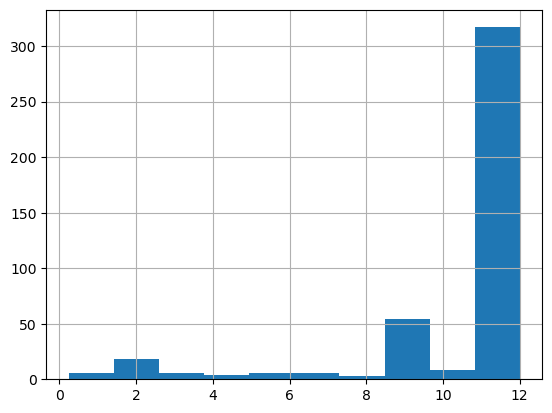

In [3]:
data.X.HeartRate_sleep_hours.hist()

In [10]:
import pandas as pd
print(pd.value_counts(data.X.dtypes))


float64    252
int64        6
dtype: int64


In [10]:
import pandas as pd
pd.concat([data.X_test.reset_index(drop=True), data.y_test.reset_index(drop=True)], axis=1).isna().sum().sum()

0

In [12]:
1915/2508

0.7635566188197768

In [1]:
import wandb
import pandas as pd

api = wandb.Api()
runs = api.runs("sgobat/pog4_xgb_classifier")
runs_2 = api.runs("sgobat/pog4_xgb")
# Initialize a list to store feature importances from all runs
feature_importances_list = []

# Iterate through the runs and fetch feature importances
for run in runs:
    # Fetch logged feature importances from the current run
    feature_importances = {
        key.replace("feature/", ""): value
        for key, value in run.summary.items()
        if key.startswith("feature/")
    }
    
    # Append the fetched feature importances to the list
    feature_importances_list.append(feature_importances)


for run in runs_2:
    # Fetch logged feature importances from the current run
    feature_importances = {
        key.replace("feature/", ""): value
        for key, value in run.summary.items()
        if key.startswith("feature/")
    }
    
    # Append the fetched feature importances to the list
    feature_importances_list.append(feature_importances)

# Create a DataFrame from the list of feature importances
df = pd.DataFrame(feature_importances_list)

# Calculate the mean feature importances across all runs
mean_feature_importances = df.sum().sort_values(ascending=False)

In [2]:
with pd.option_context("display.max_rows", 1000):
    display(mean_feature_importances)

AppleStandTime_max_hrs_between                    2.264525
AppleStandTime_max_endDate_hr                     2.018761
AppleExerciseTime_max_hrs_between                 1.382840
StairDescentSpeed_min_endDate_hr                  1.329650
StairDescentSpeed_max_endDate_hr                  1.257696
AppleStandTime_nhours_max_max                     1.256580
AppleStandTime_min_startDate_hr                   1.240403
FlightsClimbed_max_endDate_hr                     1.236439
min_endDate_max_hr                                1.200462
AppleStandTime_nhours_min_max                     1.189877
min_startDate_max_hr                              1.188407
FlightsClimbed_min_endDate_hr                     1.176989
appleStandHours                                   1.172165
BasalEnergyBurned                                 1.170610
month                                             1.166317
month_sin                                         1.127710
FlightsClimbed_nhours_min_max                     1.1061

In [3]:
feat_imp_threshold = mean_feature_importances.median() - 1*mean_feature_importances.std()
print(feat_imp_threshold)

for i in mean_feature_importances.index:
    if mean_feature_importances[i] > feat_imp_threshold:
        print(i)

0.23076614940345674
AppleStandTime_max_hrs_between
AppleStandTime_max_endDate_hr
AppleExerciseTime_max_hrs_between
StairDescentSpeed_min_endDate_hr
StairDescentSpeed_max_endDate_hr
AppleStandTime_nhours_max_max
AppleStandTime_min_startDate_hr
FlightsClimbed_max_endDate_hr
min_endDate_max_hr
AppleStandTime_nhours_min_max
min_startDate_max_hr
FlightsClimbed_min_endDate_hr
appleStandHours
BasalEnergyBurned
month
month_sin
FlightsClimbed_nhours_min_max
WalkingSpeed_max_startDate_hr
min_startDate_min_hr
day_of_year
doy_cos
OxygenSaturation
DistanceWalkingRunning_max_startDate_hr
DistanceWalkingRunning_nhours_max_max
HeartRateVariabilitySDNN_nhours_min_min
FlightsClimbed_nhours_max_max
appleExerciseTime
min_endDate_min_hr
BasalEnergyBurned_max_hrs_between
AppleStandHour_nhours_max_max
month_cos
StairDescentSpeed_max_hrs_between
AppleStandTime_min_endDate_hr
distance_per_step
HeartRateVariabilitySDNN_min_endDate_hr
WalkingHeartRateAverage
FlightsClimbed_nhours_min_min
StepCount_nhours_min_max

In [ ]:
[
"AppleStandTime_hrs_btween",
"BodyMassIndex_hrs_btween",
"OxygenSaturation_hrs_btween",
"is_weekend",
"appleExerciseTime",
"AppleStandTime",
"AppleStandHour_hrs_btween",
"VO2Max",
"AppleExerciseTime_hrs_btween",
"dow_median",
"appleStandHours",
"AppleStandTime_night_hours",
"AppleExerciseTime",
"day_of_week",
"avg_endDate_max_sin",
"max_startDate_min_hr",
"activeEnergyBurned",
"avg_startDate_min_sin",
"avg_startDate_min_hr",
"calorie_per_step",
"DistanceWalkingRunning_night_hours",
"month_sin",
"HeadphoneAudioExposure",
"avg_startDate_min_cos",
"max_endDate_min_hr",
"FlightsClimbed_hrs_btween",
"avg_endDate_min_sin",
"avg_endDate_max_cos",
"calorie_per_distance",
"HeartRateVariabilitySDNN_hrs_btween",
"DistanceWalkingRunning_hrs_btween",
"min_endDate_max_hr",
"StepCount_night_hours",
"FlightsClimbed_night_hours",
"distance_per_step",
"day_of_year",
"max_startDate_max_hr",
"min_endDate_min_hr",
"min_startDate_min_hr",
"StepCount_hrs_btween",
"BodyMassIndex",
"VO2Max_hrs_btween",
"doy_sin",
"month",
"month_cos",
"avg_startDate_max_sin",
"DistanceWalkingRunning",
"HeadphoneAudioExposure_hrs_btween",
"AppleExerciseTime_night_hours",
]

In [40]:
import pandas as pd
apple_stand_time = pd.read_csv("./data/xml_export/AppleStandTime.csv", low_memory=False)

In [53]:
df = apple_stand_time.copy()

def calculate_night_hours(df):
    df['startDate'] = pd.to_datetime(df['startDate'])
    df['endDate'] = pd.to_datetime(df['endDate'])

    # Define the time range for night time
    start_hour = 20  # 8 PM
    end_hour = 8  # 8 AM

    df = df[((df['startDate'].dt.hour >= start_hour) & (df['startDate'].dt.hour < 24)) |
                ((df['endDate'].dt.hour >= 0) & (df['endDate'].dt.hour < end_hour))]

    df['adjusted_startDate'] = (df['startDate'] - pd.to_timedelta('12:00:00')).dt.date # Subtract 12 hours from startDate
    df = df.groupby(['adjusted_startDate', 'sourceName']).agg(startDate=('startDate', 'min'), endDate=('endDate', 'max'), totalValue=('value', 'sum')).reset_index()
    df["night_hours"] = (df['endDate'] - df['startDate']).dt.total_seconds() / 3600

    return df

df = calculate_night_hours(df)
df.head(10)

,adjusted_startDate,sourceName,startDate,endDate,totalValue,night_hours
0,2020-09-25,Rob’s Apple Watch,2020-09-25 20:05:00-04:00,2020-09-26 02:55:00-04:00,29,6.833333
1,2020-09-26,Rob’s Apple Watch,2020-09-26 20:00:00-04:00,2020-09-27 07:25:00-04:00,23,11.416667
2,2020-09-27,Rob’s Apple Watch,2020-09-27 22:45:00-04:00,2020-09-28 07:50:00-04:00,14,9.083333
3,2020-09-28,Rob’s Apple Watch,2020-09-28 21:45:00-04:00,2020-09-29 07:40:00-04:00,12,9.916667
4,2020-09-29,Rob’s Apple Watch,2020-09-29 21:15:00-04:00,2020-09-30 07:40:00-04:00,15,10.416667
5,2020-09-30,Rob’s Apple Watch,2020-09-30 21:00:00-04:00,2020-09-30 22:55:00-04:00,18,1.916667
6,2020-10-01,Rob’s Apple Watch,2020-10-01 21:00:00-04:00,2020-10-02 00:10:00-04:00,32,3.166667
7,2020-10-02,Rob’s Apple Watch,2020-10-02 20:00:00-04:00,2020-10-03 07:55:00-04:00,19,11.916667
8,2020-10-03,Rob’s Apple Watch,2020-10-03 20:05:00-04:00,2020-10-04 00:00:00-04:00,26,3.916667
9,2020-10-04,Rob’s Apple Watch,2020-10-04 21:55:00-04:00,2020-10-05 07:00:00-04:00,9,9.083333


<Axes: >

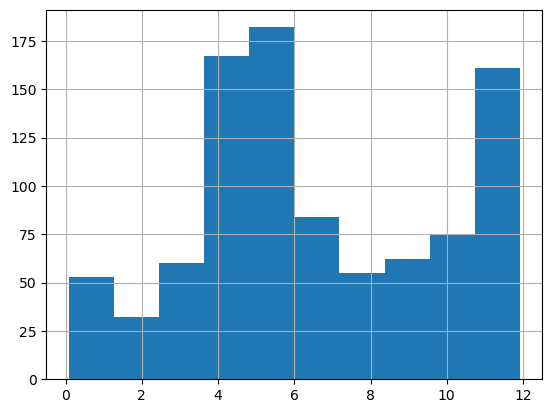

In [54]:
df.night_hours.hist()

In [55]:
#See where sourcename is Rob’s Apple Watch
df[df['sourceName'] == "Rob's Apple Watch"]

,adjusted_startDate,sourceName,startDate,endDate,totalValue,night_hours


In [56]:
import pandas as pd
df = apple_stand_time.copy()

# Assuming your dataframe is named df, and has columns 'startDate' and 'endDate'
# Ensure the columns are in datetime format
df['startDate'] = pd.to_datetime(df['startDate'])
df['endDate'] = pd.to_datetime(df['endDate'])

# Define the time range for night time
start_hour = 20  # 8 PM
end_hour = 8  # 8 AM

# Filter the dataframe based on the specified time range
df_night = df[((df['startDate'].dt.hour >= start_hour) & (df['startDate'].dt.hour < 24)) |
              ((df['endDate'].dt.hour >= 0) & (df['endDate'].dt.hour < end_hour))]



# Group by the date and find min startDate and max endDate
df_night['startDate_date'] = df_night['startDate'].dt.date
df_night['endDate_date'] = df_night['endDate'].dt.date
df_night_grouped = df_night.groupby(['startDate_date', 'endDate_date']).agg({'startDate': 'min', 'endDate': 'max'}).reset_index()

# Hours beteween start and enddate
df_night_grouped['hrs_btween'] = (df_night_grouped['endDate'] - df_night_grouped['startDate']).dt.total_seconds() / 3600

# Display the resul
df_night_grouped.head(10)



,startDate_date,endDate_date,startDate,endDate,hrs_btween
0,2020-09-25,2020-09-25,2020-09-25 20:05:00-04:00,2020-09-25 23:45:00-04:00,3.666667
1,2020-09-26,2020-09-26,2020-09-26 00:00:00-04:00,2020-09-26 23:35:00-04:00,23.583333
2,2020-09-27,2020-09-27,2020-09-27 07:20:00-04:00,2020-09-27 22:50:00-04:00,15.500000
3,2020-09-28,2020-09-28,2020-09-28 00:20:00-04:00,2020-09-28 23:05:00-04:00,22.750000
4,2020-09-29,2020-09-29,2020-09-29 07:35:00-04:00,2020-09-29 22:35:00-04:00,15.000000
5,2020-09-30,2020-09-30,2020-09-30 07:00:00-04:00,2020-09-30 22:55:00-04:00,15.916667
6,2020-10-01,2020-10-01,2020-10-01 21:00:00-04:00,2020-10-01 23:35:00-04:00,2.583333
7,2020-10-01,2020-10-02,2020-10-01 23:55:00-04:00,2020-10-02 00:00:00-04:00,0.083333
8,2020-10-02,2020-10-02,2020-10-02 00:00:00-04:00,2020-10-02 23:25:00-04:00,23.416667
9,2020-10-03,2020-10-03,2020-10-03 06:50:00-04:00,2020-10-03 23:50:00-04:00,17.000000


In [4]:
from data import POG4_Dataset
data = POG4_Dataset()

INFO - Creating XML data
INFO - Creating activity data
INFO - Missing days: 16
INFO - Featurizing time series data
INFO - Creating interactions...
INFO - Dropped null columns: ['WalkingSpeed_nhours_min_min', 'WalkingSpeed_nhours_min_max', 'WalkingSpeed_nhours_max_min', 'WalkingSpeed_nhours_max_max', 'WalkingSpeed_min_endDate_hr', 'WalkingSpeed_max_endDate_hr', 'RunningSpeed', 'RunningSpeed_max_hrs_between', 'RunningSpeed_sum_hrs_between', 'RunningSpeed_nhours_min_min', 'RunningSpeed_nhours_min_max', 'RunningSpeed_nhours_max_min', 'RunningSpeed_nhours_max_max', 'RunningSpeed_min_endDate_hr', 'RunningSpeed_max_endDate_hr', 'RunningSpeed_min_startDate_hr', 'RunningSpeed_max_startDate_hr', 'AppleWalkingSteadiness', 'AppleWalkingSteadiness_max_hrs_between', 'AppleWalkingSteadiness_sum_hrs_between', 'AppleWalkingSteadiness_nhours_min_min', 'AppleWalkingSteadiness_nhours_min_max', 'AppleWalkingSteadiness_nhours_max_min', 'AppleWalkingSteadiness_nhours_max_max', 'AppleWalkingSteadiness_min_end

In [7]:
data.train_test_split()
data.preprocess_data()

INFO - Splitting data into train and test set
INFO - Scaling and imputing data


In [10]:
data.X_test

,workout_duration,workout_totalDistance,workout_totalDistanceUnit,workout_totalEnergyBurned,workout_totalEnergyBurnedUnit,WalkingSpeed,WalkingSpeed_max_hrs_between,WalkingSpeed_sum_hrs_between,WalkingSpeed_min_startDate_hr,WalkingSpeed_max_startDate_hr,...,min_startDate_max_hr,avg_startDate_min_hr,max_startDate_min_hr,min_startDate_min_hr,avg_endDate_max_hr,max_endDate_max_hr,min_endDate_max_hr,avg_endDate_min_hr,max_endDate_min_hr,min_endDate_min_hr
0,0.773197,0.0,0.0,0.0,0.0,3.046823,-0.824698,-1.204869,-0.021329,0.366247,...,-0.043613,0.806606,-0.067519,0.305404,-0.758610,-0.543714,-0.354063,-0.002591,-0.296391,0.304663
1,-0.533888,0.0,0.0,0.0,0.0,1.756226,-1.232150,-0.800985,-0.021329,-1.925271,...,-0.043613,0.498623,0.295983,0.305404,-0.475794,0.831912,-0.354063,-0.078058,0.928869,0.304663
2,-0.676077,0.0,0.0,0.0,0.0,1.023095,-0.986295,-1.332059,-0.021329,0.366247,...,-0.439555,0.194639,0.295983,-0.060923,-0.997849,0.144099,-0.532442,-0.343241,0.316239,-0.079694
3,-0.683396,0.0,0.0,0.0,0.0,1.873097,-1.326528,-0.586948,-0.021329,0.366247,...,0.748269,-1.292082,-1.158025,-3.724191,-0.737731,0.144099,0.002697,-1.261520,0.316239,-3.923260
4,-0.843724,0.0,0.0,0.0,0.0,2.214388,-2.365358,-0.565236,-4.958889,0.366247,...,-0.835496,-0.645316,1.749991,-1.526230,-0.837776,-0.543714,-0.710822,-1.066468,0.928869,-1.617120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,-0.192359,0.0,0.0,0.0,0.0,-1.817652,-0.248816,0.154258,-0.021329,0.366247,...,-2.419260,-0.590966,1.022987,-2.991537,-1.613422,-0.543714,-1.424341,-1.133118,-0.296391,-2.770190
112,-0.192359,0.0,0.0,0.0,0.0,-0.395127,-0.854555,-0.167061,-0.021329,0.366247,...,1.540151,0.938599,1.022987,0.305404,-0.634827,-0.543714,0.359456,-0.243367,-0.296391,0.304663
113,-0.192359,0.0,0.0,0.0,0.0,-1.505757,-0.580699,0.932125,-0.021329,0.366247,...,-0.043613,4.062433,1.749991,-0.427249,-0.293529,0.831912,-0.354063,1.894379,0.928869,-0.464050
114,2.456429,0.0,0.0,0.0,0.0,-0.728173,-0.370352,0.604195,-0.021329,0.366247,...,-0.835496,-0.141343,0.659485,-0.427249,-0.449600,0.831912,-0.710822,-0.463779,0.928869,-0.079694


In [6]:
0.8*579


463.20000000000005

In [5]:
import pandas as pd

d = pd.concat([data.y,data.X], axis=1)
d.to_csv("./regression.csv", index=False)
print(d)

     sleep_hours  is_workday  AppleStandTime_max_hrs_between  \
0       7.433333           1                             NaN   
1       6.833333           1                             NaN   
2       6.116667           1                             NaN   
3       7.333333           1                             NaN   
4       6.983333           1                             NaN   
..           ...         ...                             ...   
574     3.850000           1                       45.083333   
575     3.850000           1                             NaN   
576     6.175000           1                        6.083333   
577     5.158333           1                        4.166667   
578     5.908333           1                        2.916667   

     AppleStandTime_max_endDate_hr  FlightsClimbed_max_endDate_hr  \
0                              NaN                           23.0   
1                              NaN                           23.0   
2                       

In [4]:
 for i in data.X.columns:
     print(i)


workout_duration
workout_totalDistance
workout_totalDistanceUnit
workout_totalEnergyBurned
workout_totalEnergyBurnedUnit
WalkingSpeed
WalkingSpeed_hrs_btween
ActiveEnergyBurned
ActiveEnergyBurned_hrs_btween
ActiveEnergyBurned_night_hours
EnvironmentalAudioExposure
EnvironmentalAudioExposure_hrs_btween
EnvironmentalAudioExposure_night_hours
StairDescentSpeed
StairDescentSpeed_hrs_btween
BasalEnergyBurned
BasalEnergyBurned_hrs_btween
BasalEnergyBurned_night_hours
StairAscentSpeed
StairAscentSpeed_hrs_btween
HeartRateVariabilitySDNN
HeartRateVariabilitySDNN_hrs_btween
HeartRateVariabilitySDNN_night_hours
OxygenSaturation
OxygenSaturation_hrs_btween
OxygenSaturation_night_hours
WalkingStepLength
WalkingStepLength_hrs_btween
BodyMass
BodyMass_hrs_btween
FlightsClimbed
FlightsClimbed_hrs_btween
FlightsClimbed_night_hours
HeadphoneAudioExposure
HeadphoneAudioExposure_hrs_btween
StepCount
StepCount_hrs_btween
StepCount_night_hours
StepCount_sleep_hours
WalkingAsymmetryPercentage
WalkingAsymmet

<Axes: >

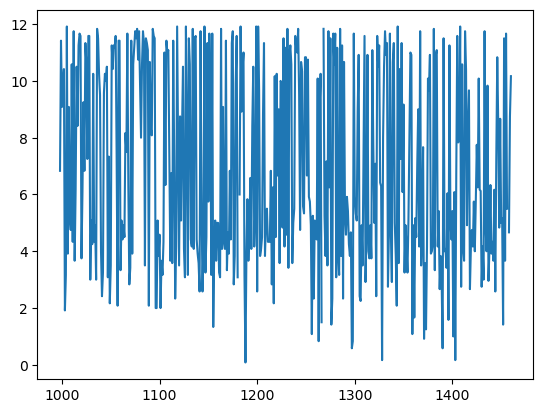

In [7]:
data.X["AppleStandTime_night_hours"].plot()

In [30]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

import numpy as np

import xgboost as xgb

# Mean all columns that end in night_hours
X = data.X[1000:].filter(like="night_hours")
y = data.y[1000:]


model = xgb.XGBRegressor(gpu_id=0, tree_method="gpu_hist", random_state=42)

# Set up the cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Scaler
scaler = StandardScaler()

# Imputer 
imputer = SimpleImputer(strategy="mean")

pipeline = Pipeline(steps=[("imputer", imputer), ("scaler", scaler), ("model", model)])

# Perform cross-validation and calculate metrics
cv_scores = cross_val_score(model, X, y, cv=tscv, scoring="neg_mean_squared_error")
rmse_scores = np.sqrt(-cv_scores)
avg_rmse = np.mean(rmse_scores)
print(f"Average RMSE: {avg_rmse:.2f}")

Average RMSE: 0.92


### Stair Ascent/Descent

In [11]:
ascent = pd.read_csv("./data/xml_export/StairAscentSpeed.csv", low_memory=False)
ascent["type"] = "ascent"
descent = pd.read_csv("./data/xml_export/StairDescentSpeed.csv", low_memory=False)
descent["type"] = "descent"

stairs = pd.concat([ascent, descent], axis=0)
stairs.head()

,sourceName,sourceVersion,device,type,unit,creationDate,startDate,endDate,value
0,Rob’s Apple Watch,2420.0.54,NaN,ascent,ft/s,2020-09-25 21:59:41 -0400,2020-09-25 21:59:06 -0400,2020-09-25 21:59:13 -0400,1.172390
1,Rob’s Apple Watch,2420.0.54,NaN,ascent,ft/s,2020-09-25 22:32:43 -0400,2020-09-25 22:32:18 -0400,2020-09-25 22:32:22 -0400,1.569890
2,Rob’s Apple Watch,2420.0.54,NaN,ascent,ft/s,2020-09-26 11:20:03 -0400,2020-09-26 11:18:53 -0400,2020-09-26 11:18:59 -0400,0.992768
3,Rob’s Apple Watch,2420.0.54,NaN,ascent,ft/s,2020-09-26 12:23:50 -0400,2020-09-26 12:23:23 -0400,2020-09-26 12:23:26 -0400,2.179550
4,Rob’s Apple Watch,2420.0.54,NaN,ascent,ft/s,2020-09-26 12:49:33 -0400,2020-09-26 12:49:03 -0400,2020-09-26 12:49:14 -0400,0.754373


In [27]:
df = stairs[stairs["value"] >= 1] # Optional?

df['startDate'] = pd.to_datetime(df['startDate']).dt.tz_localize(None)
df['endDate'] = pd.to_datetime(df['endDate']).dt.tz_localize(None)

df = df.sort_values(by=['startDate', 'endDate'])

# Get the date range in the dataframe
min_date = df['startDate'].min().date()
max_date = df['endDate'].max().date()

# Initialize an empty list to store the results
results = []

# Loop through each date in the range
for date in pd.date_range(min_date, max_date):
    # startSleep time boundaries - Based on analysis of train_detailed
    start_day = pd.Timestamp.combine(date, pd.Timestamp('21:30:00').time())
    end_day = pd.Timestamp.combine(date + pd.DateOffset(1), pd.Timestamp('01:30:00').time())
    
    # endSleep time boundaries - Based on analysis of train_detailed
    start_night = pd.Timestamp.combine(date + pd.DateOffset(1), pd.Timestamp('06:30:00').time())
    end_night = pd.Timestamp.combine(date + pd.DateOffset(1), pd.Timestamp('9:30:00').time())

    # Filter the dataframe for max_endDate
    mask_endDate = ((df['endDate'] >= start_day)) & ((df['endDate'] <= end_day))
    filtered_df_endDate = df[mask_endDate]

    # Filter the dataframe for min_startDate
    mask_startDate = ((df['startDate'] >= start_night)) & ((df['startDate'] <= end_night))
    filtered_df_startDate = df[mask_startDate]

    # Find max_endDate and min_startDate
    min_endDate = filtered_df_endDate['endDate'].min() # if not filtered_df_endDate.empty else pd.to_datetime(start_day)
    max_endDate = filtered_df_endDate['endDate'].max() # if not filtered_df_endDate.empty else pd.to_datetime(end_day)
    min_startDate = filtered_df_startDate['startDate'].min() # if not filtered_df_startDate.empty else pd.to_datetime(start_night)
    max_startDate = filtered_df_startDate['startDate'].max() # if not filtered_df_startDate.empty else pd.to_datetime(end_night)

    # Append the results to the list
    results.append({
        'date': date,
        'min_endDate': min_endDate, # Min Possible Start Sleeping
        'max_endDate': max_endDate, # Max Possible Start Sleeping
        'min_startDate': min_startDate, # Min Possible End Sleeping
        'max_startDate': max_startDate # Max Possible End Sleeping
    })

# Convert the results to a dataframe and return
result_df = pd.DataFrame(results)

# Time Differences in hours # Attempt to manually calculate sleep time - doesn't work, but still useful
result_df["nhours_min_min"] = (result_df["min_startDate"] - result_df["min_endDate"]).dt.total_seconds() / 3600
result_df["nhours_min_max"] = (result_df["min_startDate"] - result_df["max_endDate"]).dt.total_seconds() / 3600
result_df["nhours_max_min"] = (result_df["max_startDate"] - result_df["min_endDate"]).dt.total_seconds() / 3600
result_df["nhours_max_max"] = (result_df["max_startDate"] - result_df["max_endDate"]).dt.total_seconds() / 3600

# Hours
result_df["min_endDate_hr"] = result_df["min_endDate"].dt.hour
result_df["max_endDate_hr"] = result_df["max_endDate"].dt.hour
result_df["min_startDate_hr"] = result_df["min_startDate"].dt.hour
result_df["max_startDate_hr"] = result_df["max_startDate"].dt.hour

In [28]:
result_df.nhours_min_max.isna().value_counts()

True     593
False    311
Name: nhours_min_max, dtype: int64